<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/ResneVGG35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install keras==2.3.1 tensorflow==1.14.0
import numpy as np, cv2, gc
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, concatenate, BatchNormalization, PReLU
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import keras.backend as K


In [44]:
import tensorflow as tf  # Make sure this is imported

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1. - dice


In [45]:
def decoder_block_simple(x, name, num_filters=32):
    x = Conv2D(num_filters, (3, 3), padding='same', name=f'{name}_conv')(x)
    x = BatchNormalization(name=f'{name}_bn')(x)
    x = PReLU(name=f'{name}_prelu')(x)
    return x


In [47]:
def unet_resnet(input_size=(224, 224, 3), decoder_block=decoder_block_simple):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_size)

    # Encoder feature maps
    encoder1 = base_model.get_layer('conv1_relu').output
    encoder2 = base_model.get_layer('conv2_block3_out').output
    encoder3 = base_model.get_layer('conv3_block4_out').output
    encoder4 = base_model.get_layer('conv4_block6_out').output
    bottleneck = base_model.get_layer('conv5_block3_out').output

    # Decoder path
    center = decoder_block(bottleneck, 'center', num_filters=512)
    x = UpSampling2D()(center)
    x = concatenate([x, encoder4])
    x = decoder_block(x, 'decoder4', num_filters=256)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder3])
    x = decoder_block(x, 'decoder3', num_filters=128)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder2])
    x = decoder_block(x, 'decoder2', num_filters=64)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder1])
    x = decoder_block(x, 'decoder1', num_filters=32)

    x = UpSampling2D()(x)
    x = decoder_block(x, 'decoder_output', num_filters=16)
    output = Conv2D(1, (1, 1), activation='sigmoid', name='prediction')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[my_iou_metric])
    return model


In [48]:
model = unet_resnet()
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_20[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 39,296,833 (149.91 MB)

 Trainable params: 39,241,697 (149.70 MB)

 Non-trainable params: 55,136 (215.38 KB)

In [49]:
from keras.applications.vgg16 import VGG16


In [66]:
def unet_vgg(input_size=(224, 224, 3), decoder_block=decoder_block_simple):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    # Encoder feature maps
    encoder1 = base_model.get_layer('block1_conv2').output  # (112, 112, 64)
    encoder2 = base_model.get_layer('block2_conv2').output  # (56, 56, 128)
    encoder3 = base_model.get_layer('block3_conv3').output  # (28, 28, 256)
    encoder4 = base_model.get_layer('block4_conv3').output  # (14, 14, 512)
    bottleneck = base_model.get_layer('block5_conv3').output  # (7, 7, 512)

    # Decoder path
    center = decoder_block(bottleneck, 'center', num_filters=512)
    x = UpSampling2D()(center)
    x = concatenate([x, encoder4])
    x = decoder_block(x, 'decoder4', num_filters=256)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder3])
    x = decoder_block(x, 'decoder3', num_filters=128)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder2])
    x = decoder_block(x, 'decoder2', num_filters=64)

    x = UpSampling2D()(x)
    x = concatenate([x, encoder1])
    x = decoder_block(x, 'decoder1', num_filters=32)

    # Removed the extra UpSampling2D layer here
    x = decoder_block(x, 'decoder_output', num_filters=16)
    output = Conv2D(1, (1, 1), activation='sigmoid', name='prediction')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[my_iou_metric])
    return model

In [68]:
model_vgg = unet_vgg()
model_vgg.summary()


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_39[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,130,817 (92.05 MB)

 Trainable params: 24,128,801 (92.04 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [69]:
#  placeholders — replace with your actual data
X_train = np.random.rand(100, 224, 224, 3)
y_train = np.random.randint(0, 2, (100, 224, 224, 1))
X_val = np.random.rand(20, 224, 224, 3)
y_val = np.random.randint(0, 2, (20, 224, 224, 1))


In [70]:
import tensorflow as tf

def my_iou_metric(label, pred):
    # Use tf.numpy_function and explicitly set the shape of the output
    iou = tf.numpy_function(get_iou_vector, [label, pred > 0.5], tf.float64)
    iou.set_shape([])  # Set shape to a scalar, as get_iou_vector returns a single value (mean IoU)
    return iou

In [71]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for b in range(batch_size):
        t, p = A[b], B[b]
        true = np.sum(t)
        pred = np.sum(p)
        if true == 0:
            iou = 1 if pred == 0 else 0
        else:
            intersection = np.sum(t * p)
            union = true + pred - intersection
            iou = intersection / union
        metric.append(iou)
    return np.mean(metric)

In [72]:
model_resnet = unet_resnet()
model_vgg = unet_vgg()

history_resnet = model_resnet.fit(X_train, y_train, validation_data=(X_val, y_val),
                                  epochs=3, batch_size=16, verbose=1)

history_vgg = model_vgg.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=3, batch_size=16, verbose=1)


Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 185s 19s/step - loss: 1.3354 - my_iou_metric: 0.1701 - val_loss: 2.4671 - val_my_iou_metric: 0.0044
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 149s 20s/step - loss: 1.2048 - my_iou_metric: 0.3042 - val_loss: 12.8606 - val_my_iou_metric: 0.1338
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 198s 20s/step - loss: 1.1838 - my_iou_metric: 0.4295 - val_loss: 11.6375 - val_my_iou_metric: 0.2069
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 362s 49s/step - loss: 1.3008 - my_iou_metric: 0.1629 - val_loss: 1.9351 - val_my_iou_metric: 0.0739
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 369s 48s/step - loss: 1.2311 - my_iou_metric: 0.1937 - val_loss: 1.4220 - val_my_iou_metric: 0.2917
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 375s 47s/step - loss: 1.1833 - my_iou_metric: 0.4308 - val_loss: 1.4079 - val_my_iou_metric: 0.4745


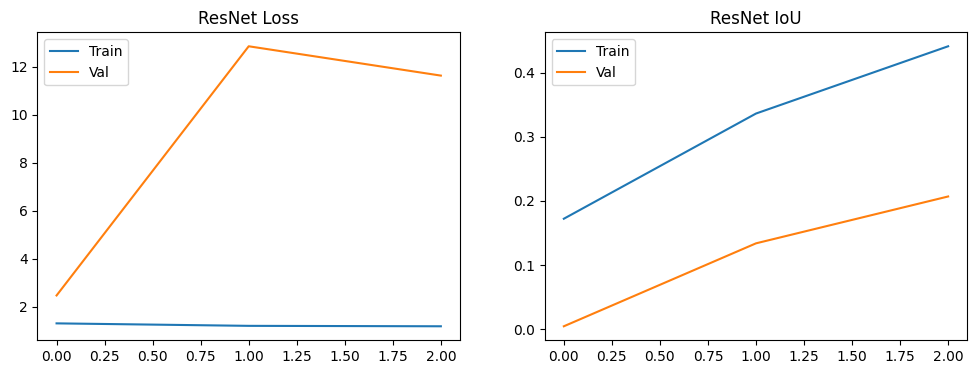

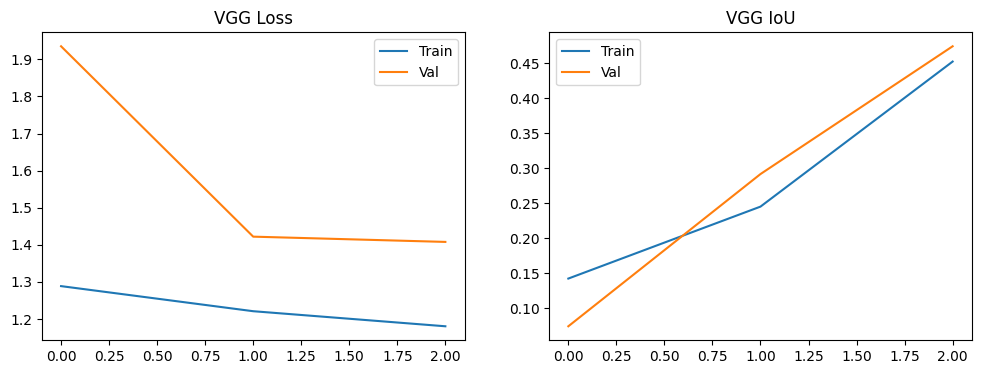

In [73]:
def plot_training(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['my_iou_metric'], label='Train')
    plt.plot(history.history['val_my_iou_metric'], label='Val')
    plt.title(f'{title} IoU')
    plt.legend()
    plt.show()

plot_training(history_resnet, "ResNet")
plot_training(history_vgg, "VGG")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


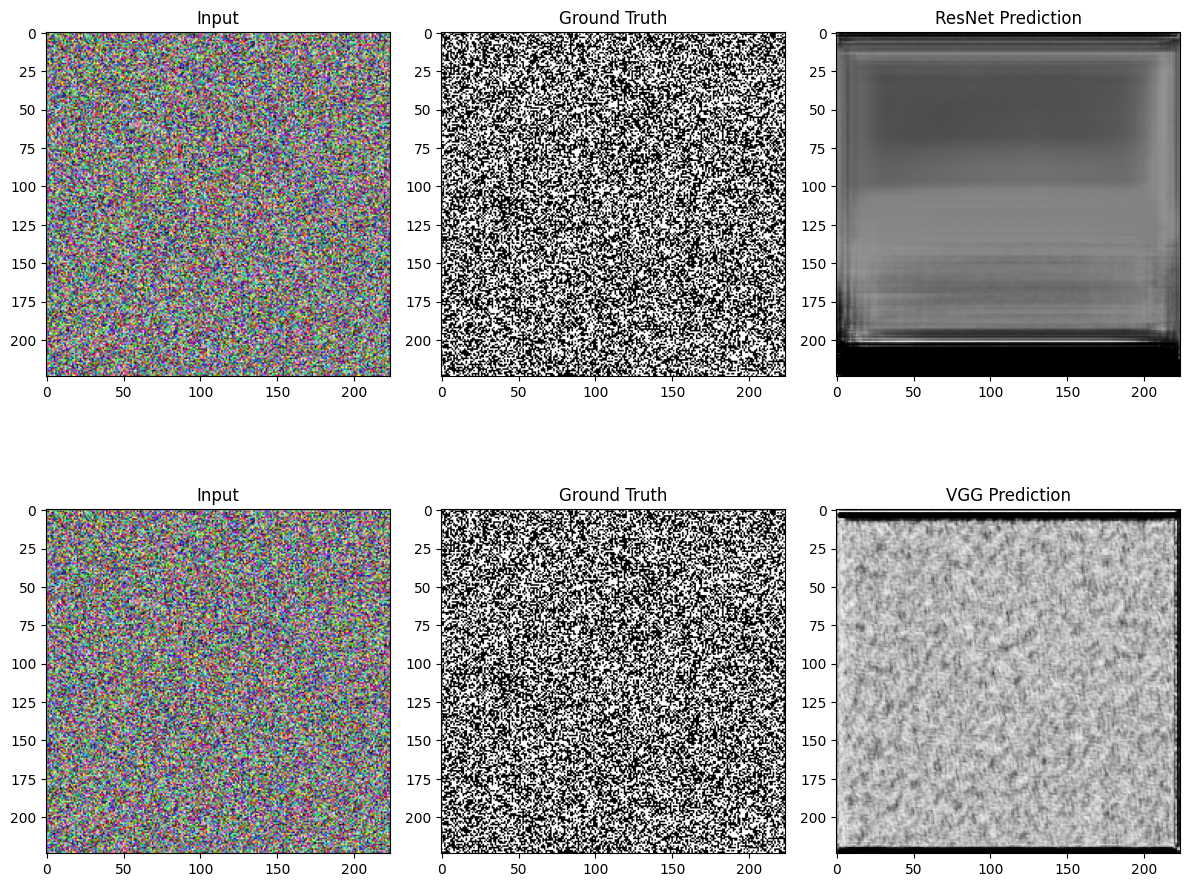

In [74]:
def compare_predictions(models, X_val, y_val, titles):
    fig, axes = plt.subplots(len(models), 3, figsize=(12, 5 * len(models)))
    for i, (model, title) in enumerate(zip(models, titles)):
        preds = model.predict(X_val[:1])[0]
        axes[i, 0].imshow(X_val[0])
        axes[i, 0].set_title("Input")
        axes[i, 1].imshow(y_val[0].squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(preds.squeeze(), cmap='gray')
        axes[i, 2].set_title(f"{title} Prediction")
    plt.tight_layout()
    plt.show()

compare_predictions([model_resnet, model_vgg], X_val, y_val, ["ResNet", "VGG"])
